In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

import utils

In [2]:
RANDOM_SEED = 42

In [3]:
(x_train, y_train), (x_val, y_val), (x_test, y_test) = utils.load_housing_data()
print(f"x_train.shape = {x_train.shape}, y_train.shape = {y_train.shape}")
print(f"x_val.shape = {x_val.shape}, y_val.shape = {y_val.shape}")
print(f"x_test.shape = {x_test.shape}, y_test.shape = {y_test.shape}")

x_train.shape = (11610, 8), y_train.shape = (11610,)
x_val.shape = (3870, 8), y_val.shape = (3870,)
x_test.shape = (5160, 8), y_test.shape = (5160,)


In [4]:
x_train_wide, x_train_deep = x_train[:, :5], x_train[:, 2:]
x_val_wide, x_val_deep = x_val[:, :5], x_val[:, 2:]
x_test_wide, x_test_deep = x_test[:, :5], x_test[:, 2:]
print(f"x_train_wide.shape = {x_train_wide.shape}, x_train_deep.shape = {x_train_deep.shape}")
print(f"x_val_wide.shape = {x_val_wide.shape}, x_val_deep.shape = {x_val_deep.shape}")
print(f"x_test_wide.shape = {x_test_wide.shape}, x_test_deep.shape = {x_test_deep.shape}")

x_train_wide.shape = (11610, 5), x_train_deep.shape = (11610, 6)
x_val_wide.shape = (3870, 5), x_val_deep.shape = (3870, 6)
x_test_wide.shape = (5160, 5), x_test_deep.shape = (5160, 6)


In [5]:
class WideAndDeepModel(keras.models.Model):
    def __init__(self, units=30, activation='relu', **kwargs):
        super().__init__(**kwargs)
        self.layer_hidden_1 = keras.layers.Dense(units, activation=activation, name="layer_hidden_1")
        self.layer_hidden_2 = keras.layers.Dense(units, activation=activation, name="layer_hidden_2")
        self.layer_output_main = keras.layers.Dense(1, name="layer_output_main")
        self.layer_output_aux = keras.layers.Dense(1, name="layer_output_aux")

    def call(self, inputs, training=None, mask=None):
        layer_input_wide, layer_input_deep = inputs
        layer_hidden_1 = self.layer_hidden_1(layer_input_deep)
        layer_hidden_2 = self.layer_hidden_2(layer_hidden_1)
        layer_concat = keras.layers.concatenate([layer_input_wide, layer_hidden_2], name="layer_concat")
        layer_output_main = self.layer_output_main(layer_concat)
        layer_output_aux = self.layer_output_aux(layer_hidden_2)
        return layer_output_main, layer_output_aux

    def get_config(self):
        pass

In [6]:
utils.reset_session(RANDOM_SEED)

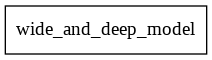

In [7]:
model = WideAndDeepModel(units=30, activation='relu')

keras.utils.plot_model(model, show_shapes=True, expand_nested=True)

In [8]:
model.compile(
    optimizer=keras.optimizers.SGD(lr=1e-3), 
    loss=['mse', 'mse'], 
    loss_weights=[0.9, 0.1]
)

history = model.fit(
    (x_train_wide, x_train_deep), 
    (y_train, y_train), 
    epochs=20, 
    validation_data=((x_val_wide, x_val_deep), (y_val, y_val))
)

Epoch 1/20
363/363 [==============================] - 1s 2ms/step - loss: 2.1365 - output_1_loss: 1.9196 - output_2_loss: 4.0890 - val_loss: 1.6233 - val_output_1_loss: 0.8468 - val_output_2_loss: 8.6117
Epoch 2/20
363/363 [==============================] - 0s 1ms/step - loss: 0.8905 - output_1_loss: 0.6969 - output_2_loss: 2.6326 - val_loss: 1.5163 - val_output_1_loss: 0.6836 - val_output_2_loss: 9.0109
Epoch 3/20
363/363 [==============================] - 0s 1ms/step - loss: 0.7429 - output_1_loss: 0.6088 - output_2_loss: 1.9499 - val_loss: 1.4639 - val_output_1_loss: 0.6229 - val_output_2_loss: 9.0326
Epoch 4/20
363/363 [==============================] - 0s 1ms/step - loss: 0.6771 - output_1_loss: 0.5691 - output_2_loss: 1.6485 - val_loss: 1.3388 - val_output_1_loss: 0.5481 - val_output_2_loss: 8.4552
Epoch 5/20
363/363 [==============================] - 0s 1ms/step - loss: 0.6381 - output_1_loss: 0.5434 - output_2_loss: 1.4911 - val_loss: 1.2177 - val_output_1_loss: 0.5194 - val_ou

In [9]:
model.predict((x_test_wide[:3], x_test_deep[:3]))

(array([[0.2676244],
        [1.980763 ],
        [3.3396287]], dtype=float32), array([[0.959365 ],
        [1.9240992],
        [2.515281 ]], dtype=float32))

## Plot subclass model

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
deep_input (InputLayer)         [(None, 6)]          0                                            
__________________________________________________________________________________________________
layer_hidden_1 (Dense)          (None, 30)           210         deep_input[0][0]                 
__________________________________________________________________________________________________
wide_input (InputLayer)         [(None, 5)]          0                                            
__________________________________________________________________________________________________
layer_hidden_2 (Dense)          (None, 30)           930         layer_hidden_1[0][0]             
_______________________________________________________________________________________

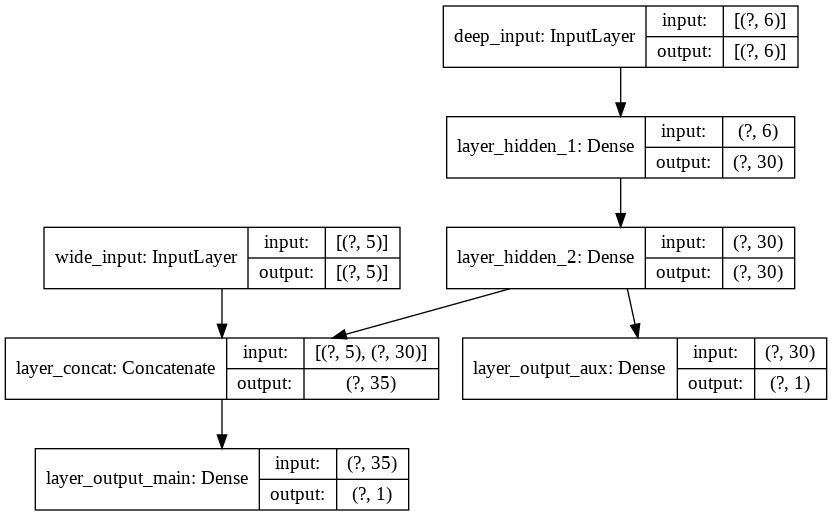

In [10]:
layer_input_wide = keras.layers.Input(shape=[5], name="wide_input")
layer_input_deep = keras.layers.Input(shape=[6], name="deep_input")

wide_and_deep_model = WideAndDeepModel(units=30, activation='relu')

plot_model = keras.models.Model(
    inputs=[layer_input_wide, layer_input_deep], 
    outputs=wide_and_deep_model.call((layer_input_wide, layer_input_deep))
)

plot_model.summary()

keras.utils.plot_model(plot_model, show_shapes=True)